In [6]:
import os
from collections import Counter

from pygam import LinearGAM, s, f
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [7]:
plt.rcParams["font.family"] = "Arial Narrow"

In [8]:
ddir = "/home/fransua/Projects/Monica_p53/data/PCHiC"

In [9]:
samples = {
    "0h" : {
        "path" : "DMSO_WT_merged_cutoff_5.ibed",
        "color": (253 / 256, 231 / 256,  36 / 256, 1),
    },
    "1h" : {
        "path" : "Nutlin3a_1h_WT_merged_cutoff_5.ibed",
        "color": ( 54 / 256, 181 / 256, 120 / 256, 1),
    },
    "10h" : {
        "path" : "Nutlin3a_10h_WT_merged_cutoff_5.ibed",
        "color": ( 66 / 256,  54 / 256, 126 / 256, 1),
    },
}

In [10]:
reso = 10_000

vals = {}
for s in samples:
    data = pd.read_csv(os.path.join(ddir, samples[s]["path"]), sep="\t", low_memory=False)
    data = data[data["bait_chr"] == data["otherEnd_chr"]]
    data["d1"] = abs(data["bait_end"]  - data["otherEnd_start"])
    data["d2"] = abs(data["bait_start"]  - data["otherEnd_end"])
    x = data[["d1", "d2"]].min(axis=1).to_numpy(dtype=int) // reso
    x = Counter(x)
    factor = sum(x.values()) / 100_000
#     factor = 1
    vals[s] = [x.get(v, 0) / factor for v in range(20_000 // reso, 1_100_000 // reso + 1)]
    vals[s].append(sum(x[v] for v in x if v > 1_100_000 // reso))

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


14.405056375600068 0.9986263698502675
19.383520719369862 0.998662680976929
19.383520719369862 0.9986374568344453


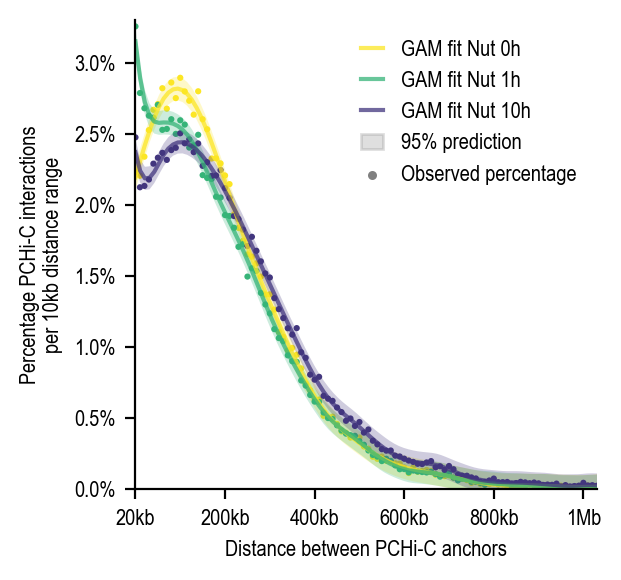

In [88]:
plt.figure(figsize=(3.2, 3), dpi=200)
ax = plt.subplot()
for w in samples:
    y = vals[w][:-5]
    X = np.asarray([[v,] for v in range(len(y))])
    gam = LinearGAM().gridsearch(X, y)
    XX = gam.generate_X_grid(term=0)
    plt.plot(XX, gam.predict(XX), '-', label=f"GAM fit Nut {w}", color=samples[w]["color"], alpha=0.75)
    y0, y1 = list(zip(*gam.prediction_intervals(XX, width=.95)))
    plt.fill_between([v[0] for v in XX], y0, y1, color=samples[w]["color"], alpha=0.25, ec='none')
    plt.scatter(X, y, facecolor=samples[w]["color"], alpha=1, edgecolors='none', s=5)
    print(gam.statistics_['edof'], gam.statistics_['pseudo_r2']['explained_deviance'])
ax.collections[-2].set_label('95% prediction')
ax.collections[-1].set_label('Observed percentage')

plt.xlim(0, len(X)-2)
plt.ylim(0, 3300)
leg = plt.legend(frameon=False, bbox_to_anchor=(1, 1), loc='upper right', handlelength=1, ncol=1, 
                 fontsize=8)

leg.legendHandles[-1].set_color('grey')
leg.legendHandles[-2].set_color('grey')

xs = [0] + list(range(20, len(X) + 2, 20))
ys = [v for v in range(0, 3500, 500)]
plt.xticks(xs, [f"{((v if v else 2) * reso) // 1_000}kb".replace("1000kb", "1Mb") for v in xs], size=8);
plt.yticks(ys, [f"{v / 1_000:.1f}%" for v in ys], size=8)
plt.xlabel("Distance between PCHi-C anchors", size=8)
plt.ylabel("Percentage PCHi-C interactions\nper 10kb distance range", size=8)
ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()
plt.savefig("/home/fransua/Projects/Monica_p53/results/PCHiC/fig4D_10kb.pdf", dpi=300)

In [66]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     19.3835
Link Function:                     IdentityLink Log Likelihood:                                  -852.9745
Number of Samples:                          105 AIC:                                              1746.716
                                                AICc:                                            1757.1415
                                                GCV:                                             1994.7208
                                                Scale:                                           1345.2361
                                                Pseudo R-Squared:                                   0.9986
Feature Function                  Lam

/tmp/ipykernel_66212/3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()
